# Reticle assembly

With gdsfactory you can easily go from a Component, to a Component sweep, to a top level Component full of subcomponents.

## Test protocols

To measure your reticle / die after fabrication you need to decide your test configurations. This includes things like:

- `Individual input and output fibers` versus `fiber array`. I reccommend `fiber array` for easier testing and higher throughtput, but also understand the flexibility of single fibers for some cases.
- Fiber array pitch (127um or 250um) if using a fiber array.
- Pad pitch for DC and RF high speed probes (100, 125, 150, 200um). Probe configuration (GSG, GS ...)
- Test layout for DC, RF and optical fibers.


To enable automatic testing you need to add labels to all the devices that you want to test. GDS labels are not fabricated and are only visible in the GDS file.

Lets show some different automatic labeling schemas:

1. SiEPIC ubc Ebeam PDK schema, labels one of the grating couplers from the fiber array.
2. `gf.dft.add_label_yaml` includes a YAML based Label with all testing information.
3. EHVA automatic testers, include a Label component declaration as described in this [doc](https://drive.google.com/file/d/1kbQNrVLzPbefh3by7g2s865bcsA2vl5l/view)


### 1. SiEPIC labels

In [1]:
import gdsfactory as gf

gf.config.set_plot_options(show_subports=False)

2022-06-16 09:51:48.365 | INFO     | gdsfactory.config:<module>:52 - Load '/home/jmatres/gdsfactory/gdsfactory' 5.10.4


INFO: index.py: Index models version: 0.5.13


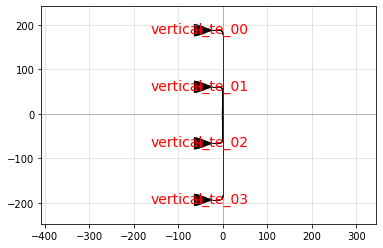

mmi2x2_add_fiber_array__1f55acce: uid 4, ports ['vertical_te_00', 'vertical_te_01', 'vertical_te_02', 'vertical_te_03'], aliases [], 0 polygons, 1 references

In [2]:
mmi = gf.components.mmi2x2()
mmi_te_siepic = gf.dft.add_fiber_array_siepic(component=mmi)
mmi_te_siepic

In [3]:
mmi_te_siepic.get_labels(depth=1)

[Label("opt_in_TE_1530_device_YourUserName_(mmi2x2)-1-o1", (-23.69999999999999, 60.699999999999996), None, None, False, 10, 0)]

### 2. YAML labels

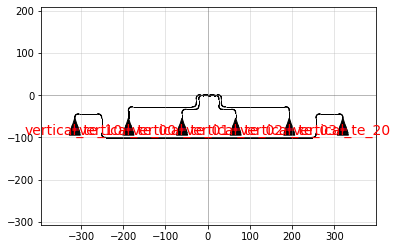

mmi2x2_add_fiber_array_459c392f: uid 23, ports ['vertical_te_00', 'vertical_te_01', 'vertical_te_02', 'vertical_te_03', 'vertical_te_10', 'vertical_te_20'], aliases [], 0 polygons, 50 references

In [4]:
mmi = gf.components.mmi2x2()
mmi_te_yaml = gf.routing.add_fiber_array(mmi, get_input_labels_function=None)
gf.dft.add_label_yaml(component=mmi_te_yaml)
mmi_te_yaml

In [5]:
mmi_te_yaml.get_labels(depth=0)

[Label("component_name: mmi2x2_add_fiber_array_459c392f
 polarization: None
 wavelength: None
 settings:
 ports:
   vertical_te_20:
     name: vertical_te_20    
     width: 11.0    
     midpoint:    
     - 320.3    
     - -80.96900000000001    
     orientation: 270.0    
     layer:    
     - 203    
     - 0    
     port_type: vertical_te    
     
   vertical_te_03:
     name: vertical_te_03    
     width: 11.0    
     midpoint:    
     - 193.3    
     - -80.96900000000001    
     orientation: 270.0    
     layer:    
     - 203    
     - 0    
     port_type: vertical_te    
     
   vertical_te_02:
     name: vertical_te_02    
     width: 11.0    
     midpoint:    
     - 66.30000000000001    
     - -80.96900000000001    
     orientation: 270.0    
     layer:    
     - 203    
     - 0    
     port_type: vertical_te    
     
   vertical_te_01:
     name: vertical_te_01    
     width: 11.0    
     midpoint:    
     - -60.699999999999996    
     - -80.969000

### 3. EHVA labels

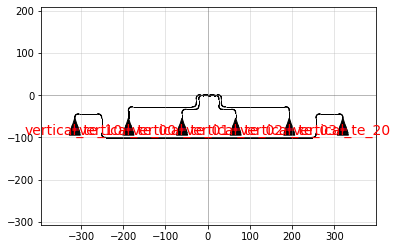

mmi2x2_add_fiber_array_459c392f: uid 23, ports ['vertical_te_00', 'vertical_te_01', 'vertical_te_02', 'vertical_te_03', 'vertical_te_10', 'vertical_te_20'], aliases [], 0 polygons, 50 references

In [6]:
mmi_te_ehva = gf.routing.add_fiber_array(mmi, get_input_labels_function=None)
mmi_te_ehva.remove_labels(lambda x: True)
gf.dft.add_label_ehva(component=mmi_te_ehva, die="mpw1")
mmi_te_ehva

In [7]:
mmi_te_ehva.get_labels(depth=0)

[Label("DIE NAME:mpw1
 CIRCUIT NAME:mmi2x2_add_fiber_array_459c392f
 
 OPTICALPORT NAME: vertical_te_20 TYPE: vertical_te, POSITION RELATIVE:(320.3, -80.969), ORIENTATION: 270
 OPTICALPORT NAME: vertical_te_03 TYPE: vertical_te, POSITION RELATIVE:(193.3, -80.969), ORIENTATION: 270
 OPTICALPORT NAME: vertical_te_02 TYPE: vertical_te, POSITION RELATIVE:(66.3, -80.969), ORIENTATION: 270
 OPTICALPORT NAME: vertical_te_01 TYPE: vertical_te, POSITION RELATIVE:(-60.7, -80.969), ORIENTATION: 270
 OPTICALPORT NAME: vertical_te_00 TYPE: vertical_te, POSITION RELATIVE:(-187.7, -80.969), ORIENTATION: 270
 OPTICALPORT NAME: vertical_te_10 TYPE: vertical_te, POSITION RELATIVE:(-314.7, -80.969), ORIENTATION: 270", (0.0, 0.0), None, None, False, 66, 0)]

One advantage of the YAML and EHVA formats is that you can track any changes on the components directly from the GDS label, as the label already stores any changes of the child device, as well as any settings that you specify.

Settings can have many levels of hierarchy, but you can still access any children setting with `:` notation.


```
grating_coupler:
    function: grating_coupler_elliptical_trenches
    settings:
        polarization: te
        taper_angle: 35

```

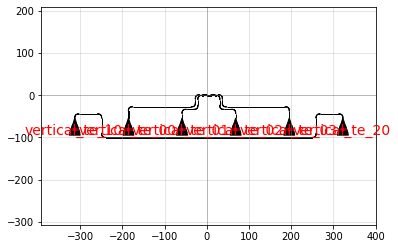

mmi2x2_length_mmi10_add_c7bd88ad: uid 60, ports ['vertical_te_00', 'vertical_te_01', 'vertical_te_02', 'vertical_te_03', 'vertical_te_10', 'vertical_te_20'], aliases [], 0 polygons, 50 references

In [8]:
mmi = gf.components.mmi2x2(length_mmi=10)
mmi_te_ehva = gf.routing.add_fiber_array(mmi, get_input_labels_function=None)
mmi_te_ehva.remove_labels(lambda x: True)
gf.dft.add_label_ehva(
    component=mmi_te_ehva,
    die="mpw1",
    metadata_include_parent=["grating_coupler:settings:polarization"],
)
mmi_te_ehva

In [9]:
mmi_te_ehva.get_labels(depth=0)

[Label("DIE NAME:mpw1
 CIRCUIT NAME:mmi2x2_length_mmi10_add_c7bd88ad
 CIRCUITINFO NAME: length_mmi, VALUE: 10
 CIRCUITINFO NAME: grating_coupler_settings_polarization, VALUE: te
 OPTICALPORT NAME: vertical_te_20 TYPE: vertical_te, POSITION RELATIVE:(322.5, -80.969), ORIENTATION: 270
 OPTICALPORT NAME: vertical_te_03 TYPE: vertical_te, POSITION RELATIVE:(195.5, -80.969), ORIENTATION: 270
 OPTICALPORT NAME: vertical_te_02 TYPE: vertical_te, POSITION RELATIVE:(68.5, -80.969), ORIENTATION: 270
 OPTICALPORT NAME: vertical_te_01 TYPE: vertical_te, POSITION RELATIVE:(-58.5, -80.969), ORIENTATION: 270
 OPTICALPORT NAME: vertical_te_00 TYPE: vertical_te, POSITION RELATIVE:(-185.5, -80.969), ORIENTATION: 270
 OPTICALPORT NAME: vertical_te_10 TYPE: vertical_te, POSITION RELATIVE:(-312.5, -80.969), ORIENTATION: 270", (0.0, 0.0), None, None, False, 66, 0)]

## Pack

Lets start with a resistance sweep, where you change the resistance width to measure sheet resistance.

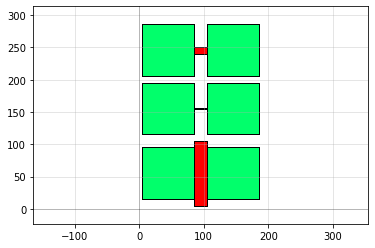

pack_0_c11d6003: uid 79, ports [], aliases [], 0 polygons, 3 references

In [10]:
sweep = [gf.components.resistance_sheet(width=width) for width in [1, 10, 100]]
m = gf.pack(sweep)
c = m[0]
c

Then we add spirals with different lengths to measure waveguide propagation loss.

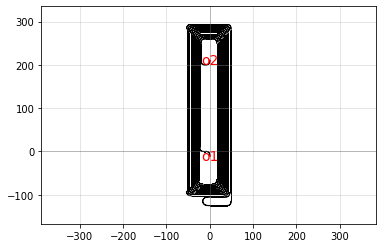

spiral_inner_io_50517bc_c5d5c76b: uid 80, ports ['o2', 'o1'], aliases [], 0 polygons, 3 references

In [11]:
spiral = gf.components.spiral_inner_io_fiber_single()
spiral

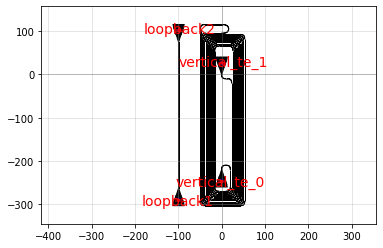

spiral_inner_io_50517bc_1d04a21c: uid 145, ports ['vertical_te_0', 'vertical_te_1', 'loopback1', 'loopback2'], aliases [], 0 polygons, 6 references

In [12]:
spiral_te = gf.routing.add_fiber_single(
    gf.functions.rotate(gf.components.spiral_inner_io_fiber_single, 90)
)
spiral_te

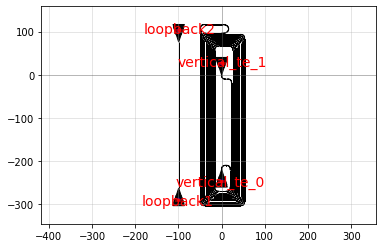

spiral_inner_io_cff9290_2eed94e1: uid 226, ports ['vertical_te_0', 'vertical_te_1', 'loopback1', 'loopback2'], aliases [], 0 polygons, 6 references

In [13]:
# which is equivalent to
spiral_te = gf.compose(
    gf.routing.add_fiber_single,
    gf.functions.rotate90,
    gf.components.spiral_inner_io_fiber_single,
)
c = spiral_te(length=10e3)
c

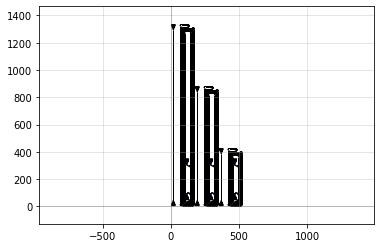

pack_0_d605b41d: uid 292, ports [], aliases [], 0 polygons, 3 references

In [14]:
import gdsfactory as gf

add_label_ehva_mpw1 = gf.partial(gf.dft.add_label_ehva, die="mpw1")
add_fiber_single_no_labels = gf.partial(
    gf.routing.add_fiber_single, get_input_label_text_function=None
)

spiral_te = gf.compose(
    add_label_ehva_mpw1,
    add_fiber_single_no_labels,
    gf.functions.rotate90,
    gf.components.spiral_inner_io_fiber_single,
)
sweep = [spiral_te(length=length) for length in [10e3, 20e3, 30e3]]
m = gf.pack(sweep)
c = m[0]
c

Together with GDS labels that are not fabricated, you can also add some physical labels that will be fabricated.

For example you can add prefix `S` at the `north-center` of each spiral using `text_rectangular` which is DRC clean and anchored on `nc` (north-center)

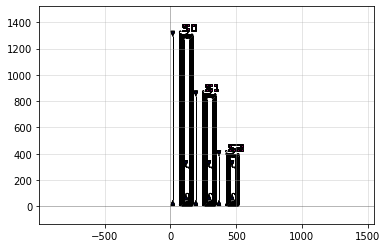

pack_0_2e7ad233: uid 293, ports [], aliases [], 0 polygons, 6 references

In [17]:
text_metal3 = gf.partial(
    gf.components.text_rectangular_multi_layer, layers=(gf.LAYER.M3,)
)

m = gf.pack(sweep, text=text_metal3, text_anchors=("nc",), text_prefix="s")
c = m[0]
c

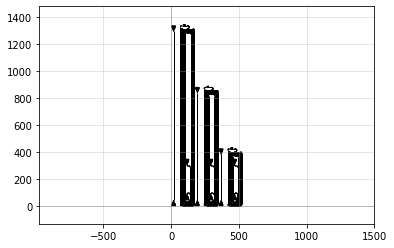

pack_0_b5463e6f: uid 304, ports [], aliases [], 0 polygons, 6 references

In [18]:
text_metal2 = gf.partial(gf.components.text, layer=gf.LAYER.M2)

m = gf.pack(sweep, text=text_metal2, text_anchors=("nc",), text_prefix="s")
c = m[0]
c

## Grid

You can also pack components with a constant spacing.

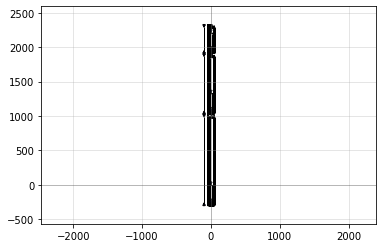

grid_dff359ef: uid 311, ports [], aliases [(0, 0), (1, 0), (2, 0)], 0 polygons, 3 references

In [19]:
g = gf.grid(sweep)
g

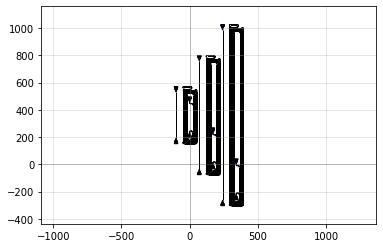

grid_744b5748: uid 313, ports [], aliases [(0, 0), (0, 1), (0, 2)], 0 polygons, 3 references

In [20]:
gh = gf.grid(sweep, shape=(1, len(sweep)))
gh

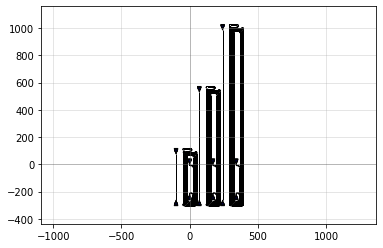

grid_32591b99: uid 315, ports [], aliases [(0, 0), (0, 1), (0, 2)], 0 polygons, 3 references

In [21]:
gh_ymin = gf.grid(sweep, shape=(1, len(sweep)), align_y="ymin")
gh_ymin

You can also add text labels to each element of the sweep

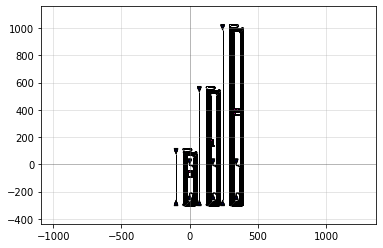

grid_with_text_bfb3bf0a: uid 317, ports [], aliases [], 0 polygons, 4 references

In [22]:
gh_ymin = gf.grid_with_text(
    sweep, shape=(1, len(sweep)), align_y="ymin", text=text_metal3
)
gh_ymin

You can modify the text by customizing the `text_function` that you pass to `grid_with_text`

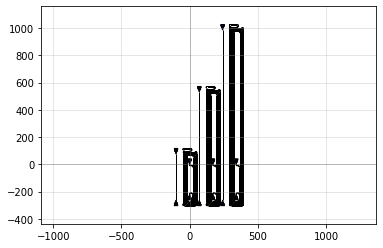

grid_with_text_89e29f39: uid 324, ports [], aliases [], 0 polygons, 4 references

In [23]:
gh_ymin_m2 = gf.grid_with_text(
    sweep, shape=(1, len(sweep)), align_y="ymin", text=text_metal2
)
gh_ymin_m2

You have 2 ways of defining a mask:

1. in python
2. in YAML


## Component in python

You can define a Component top cell reticle or die using `grid` and `pack` python functions.

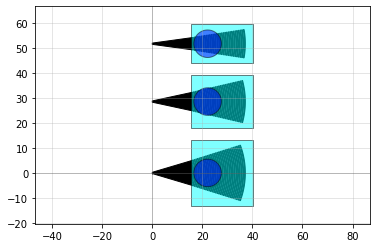

grid_with_text_eae496e4: uid 334, ports [], aliases [], 0 polygons, 1 references

In [24]:
import gdsfactory as gf

text_metal3 = gf.partial(
    gf.components.text_rectangular_multi_layer, layers=(gf.LAYER.M3,)
)
grid = gf.partial(gf.grid_with_text, text=text_metal3)
pack = gf.partial(gf.pack, text=text_metal3)

gratings_sweep = [
    gf.components.grating_coupler_elliptical(taper_angle=taper_angle)
    for taper_angle in [20, 30, 40]
]
gratings = grid(gratings_sweep, text=None)
gratings

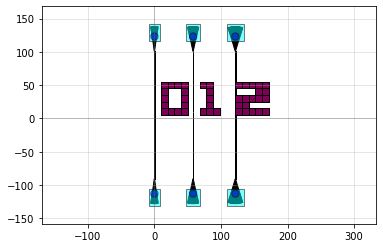

grid_with_text_b6edda8c: uid 360, ports [], aliases [], 0 polygons, 4 references

In [25]:
gratings_sweep = [
    gf.components.grating_coupler_elliptical(taper_angle=taper_angle)
    for taper_angle in [20, 30, 40]
]
gratings_loss_sweep = [
    gf.components.grating_coupler_loss_fiber_single(grating_coupler=grating)
    for grating in gratings_sweep
]
gratings = grid(
    gratings_loss_sweep, shape=(1, len(gratings_loss_sweep)), spacing=(40, 0)
)
gratings

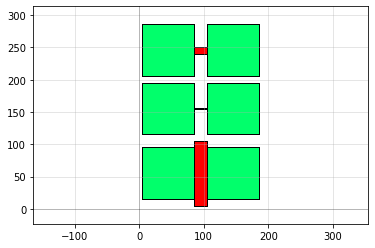

pack_0_c1dd66c1: uid 363, ports [], aliases [], 0 polygons, 3 references

In [26]:
sweep_resistance = [
    gf.components.resistance_sheet(width=width) for width in [1, 10, 100]
]
resistance = gf.pack(sweep_resistance)[0]
resistance

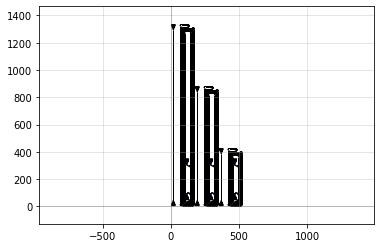

pack_0_1513c986: uid 366, ports [], aliases [], 0 polygons, 3 references

In [27]:
spiral_te = gf.compose(
    gf.routing.add_fiber_single,
    gf.functions.rotate90,
    gf.components.spiral_inner_io_fiber_single,
)
sweep_spirals = [spiral_te(length=length) for length in [10e3, 20e3, 30e3]]
spirals = gf.pack(sweep_spirals)[0]
spirals

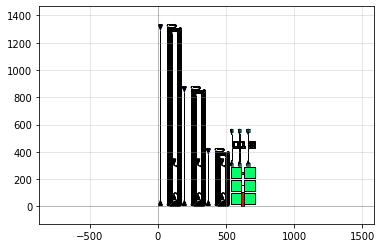

pack_0_c7cd4855: uid 367, ports [], aliases [], 0 polygons, 3 references

In [28]:
mask = gf.pack([spirals, resistance, gratings])[0]
mask

As you can see you can define your mask in a single line.

For more complex mask, you can also create a new cell to build up more complexity

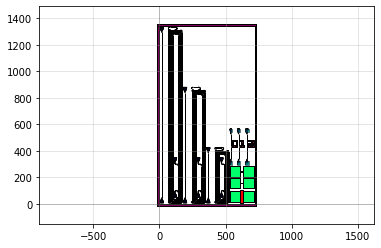

mask: uid 368, ports [], aliases [], 0 polygons, 2 references

In [29]:
@gf.cell
def mask():
    c = gf.Component()
    c << gf.pack([spirals, resistance, gratings])[0]
    c << gf.components.seal_ring(c.bbox)
    return c


c = mask(cache=False)
c

## Metadata

When saving GDS files is also convenient to store the metadata settings that you used to generate the GDS file.

In [30]:
gdspath = c.write_gds_with_metadata(gdsdir="extra")

2022-06-16 09:57:08.753 | INFO     | gdsfactory.component:write_gds:1040 - Write GDS to 'extra/mask.gds'
2022-06-16 09:57:10.206 | INFO     | gdsfactory.component:write_gds_with_metadata:1048 - Write YAML metadata to 'extra/mask.yml'


In [31]:
yaml_path = gdspath.with_suffix(".yml")

In [32]:
labels_path = gf.mask.write_labels(gdspath=gdspath, layer_label=(201, 0))

2022-06-16 09:57:16.230 | INFO     | gdsfactory.mask.write_labels:write_labels:84 - Wrote 18 labels to CSV /home/jmatres/gdsfactory/docs/notebooks/extra/mask.csv


In [33]:
from omegaconf import OmegaConf

mask_metadata = OmegaConf.load(yaml_path)

In [34]:
test_metadata = tm = gf.mask.merge_test_metadata(
    labels_path=labels_path, mask_metadata=mask_metadata
)

In [ ]:
tm.keys()

```

CSV labels  ------|
                  |--> merge_test_metadata dict
                  |
YAML metatada  ---

```

In [ ]:
spiral_names = [s for s in test_metadata.keys() if s.startswith("spiral")]
spiral_names

In [ ]:
spiral_lengths = [
    test_metadata[spiral_name].info.length for spiral_name in spiral_names
]
spiral_lengths

In [ ]:
gc_names = [s for s in test_metadata.keys() if s.startswith("grating")]
gc_names

In [ ]:
gc_taper_angles = [test_metadata[name].full.taper_angle for name in gc_names]
gc_taper_angles

## Component in YAML

You can also define your component in YAML format thanks to `gdsfactory.read.from_yaml`

You need to define:

- instances
- placements

and you can leverage:

1. `pack_doe`
2. `pack_doe_grid`

### 1. pack_doe

`pack_doe` places components as compact as possible

When running this tutorial make sure you UNCOMMENT this line `%matplotlib widget` so you can live update your changes in the YAML file

`# %matplotlib widget`  -> `%matplotlib widget`

In [ ]:
# %matplotlib widget

import ipywidgets
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gdsfactory as gf

x = ipywidgets.Textarea(rows=20, columns=480)

x.value = """
name: mask_grid

instances:
  rings:
    component: pack_doe
    settings:
      doe: ring_single
      settings:
        radius: [30, 50, 20, 40]
        length_x: [1, 2, 3]
      do_permutations: True
      function:
        function: add_fiber_array
        settings:
            fanout_length: 200

  mzis:
    component: pack_doe
    settings:
      doe: mzi
      settings:
        delta_length: [10, 100]
      function: add_fiber_array

placements:
  rings:
    xmin: 50

  mzis:
    xmin: rings,east
"""

out = ipywidgets.Output()
display(x, out)


def f(change, out=out):
    try:
        c = gf.read.from_yaml(change["new"])
        # clear_output()
        fig = c.plot()
        c.show()
        out.clear_output()
    except Exception as e:
        out.clear_output()
        with out:
            display(e)


x.observe(f, "value")
f({"new": x.value})

### 2. pack_doe_grid

`pack_doe_grid` places each component on a regular grid

In [ ]:
x.value = """
name: mask_compact

instances:
  rings:
    component: pack_doe
    settings:
      doe: ring_single
      settings:
        radius: [30, 50, 20, 40]
        length_x: [1, 2, 3]
      do_permutations: True
      function:
        function: add_fiber_array
        settings:
            fanout_length: 200


  mzis:
    component: pack_doe_grid
    settings:
      doe: mzi
      settings:
        delta_length: [10, 100]
      do_permutations: True
      spacing: [10, 10]
      function: add_fiber_array

placements:
  rings:
    xmin: 50

  mzis:
    xmin: rings,east
"""

display(x, out)